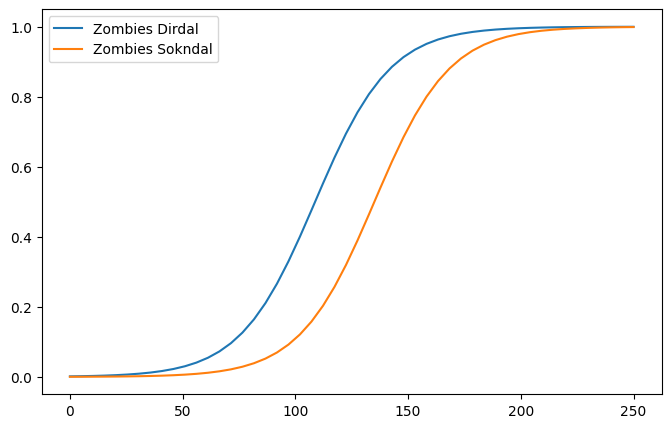

In [290]:
from doctest import debug_script

import numpy as np
import matplotlib.pyplot as plt
from win32netcon import SHI1005_FLAGS_DFS

beta = 0.06
N_dirdal = 683
N_sokndal = 3305
Z0 = 1


def SZ_solution(t, N, Z0=1):
    S0 = N - Z0
    S = (S0 * (S0/Z0) * np.exp(-beta*t)) / (1 + (S0/Z0) * np.exp(-beta*t))
    Z = (S0 + Z0) / (1 + (S0/Z0) * np.exp(-beta*t))
    return S, Z


t = np.linspace(0, 250)

S_d, Z_d = SZ_solution(t, N_dirdal)
S_s, Z_s = SZ_solution(t, N_sokndal)

#må dele på befolkning for å få like reprensativt tall
Z_d_frac = Z_d / N_dirdal
Z_s_frac = Z_s / N_sokndal

# plotting
plt.figure(figsize=(8,5))
plt.plot(t, Z_d_frac, label="Zombies Dirdal")
plt.plot(t, Z_s_frac, label="Zombies Sokndal")


plt.legend()

plt.show()

In [291]:

def ode_solver_adaptiv(t0, t_final, c0, eps, f, *args, **kwargs):
    c = []
    t = []
    c.append(c0)  # initial conditions
    t.append(t0)
    dt_old = 1e-5
    while (t[-1] < t_final):
        c_old = c[-1]
        eps_calc = 10 * eps
        while (eps_calc > eps):
            dt = dt_old
            c_long = (c_old + dt * f(t[-1], c_old, *args, **kwargs))
            c_half = (c_old + 0.5 * dt * f(t[-1], c_old, *args, **kwargs))
            c_two_half = (c_half + 0.5 * dt * f(t[-1] + 0.5 * dt, c_half, *args, **kwargs))
            eps_calc = np.linalg.norm(c_two_half - c_long)
            eps_calc = np.ceil(eps_calc * 1e5) / 1e5
            dt_old = dt * np.sqrt(eps / eps_calc)
        c.append(2 * c_two_half - c_long)  # Euler
        t.append(t[-1] + dt)
    return np.array(t), np.array(c)

In [4]:
def step(dt,f, t,c_old, method, *args, **kwargs):
    if method == 'ode':
        return dt*f(t,c_old,*args, **kwargs)
    elif method == 'R_K':
        k1 = dt*f(t,c_old,*args, **kwargs)
        return dt*f(t+dt*0.5,c_old+0.5*k1,*args, **kwargs)
    else:
        raise ValueError('method must be ode or rhs')

# Euler
def ode_solver_2(t0, t_final, c0, dt, f, method,  *args, **kwargs):
    """
    A simple ODE solver

    Input
    -----
    t0: float, starting time
    t_final: float, end time
    c0: float, initial condition
    dt: float, step size
    f: ode function (rhs) f(t,c,tau)
    tau: float, a parameter

    Output
    -----
    t, c  dt*f(t,c_old,*args, **kwargs)
    """
    N = int(t_final/dt) + 1  # calculate number of steps
    c = []
    t = []
    c.append(c0) # initial conditions
    t.append(t0)
    for i in range(N):
        c_old = c[-1]
        c_old = np.array(c_old)
        t_old = t[-1]
        c.append(c_old + step(dt,f, t_old,c_old,method, *args, **kwargs)) # Euler
        t.append(t[-1]+dt)
    return np.array(t), np.array(c)

In [293]:
def step(t, c_old, dt, f, method, *args, **kwargs):
    """
    Awesome doc string
    """
    if method == 'Euler':
        return dt*f(t, c_old, *args, **kwargs)
    elif method == 'RK2':
        k1 = np.array(dt*f(t, c_old, *args, **kwargs))
        return dt*f(t+dt*0.5, c_old + 0.5*k1, *args, **kwargs)
    elif method == 'RK4':
        k1 = np.array(f(t, c_old, *args, **kwargs))
        k2 = np.array(f(t + dt * 0.5, c_old + 0.5 * dt * k1, *args, **kwargs))
        k3 = np.array(f(t + dt * 0.5, c_old + 0.5 * dt * k2, *args, **kwargs))
        k4 = np.array(f(t + dt, c_old + dt * k3, *args, **kwargs))
        return (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    else:
        raise ValueError('Method ot implemented')


def ode_solver_adaptiv(t0, t_final, c0, eps, f, method, *args, **kwargs):
    """
    A simple ODE solver

    Input
    -----
    t0: float, starting time
    t_final: float, end time
    c0: float, initial condition
    eps: float, accuracy
    f: ode function (rhs) f(t,c,tau)
    tau: float, a parameter

    Output
    -----
    t, c
    """
    c = []
    t = []
    c.append(c0) # initial conditions
    t.append(t0)
    dt_old = 1e-2
    if method == 'Euler':
        p = 1
    elif method == 'RK2':
        p = 2
    elif method == 'RK4':
        p = 4
    else:
        assert ValueError('Method not implemented')
    while t[-1] < t_final:
        c_old = c[-1]
        eps_calc = 10*eps #just to enter while loop
        while eps_calc > eps:
            dt = dt_old
            c_long = c_old + step(t[-1], c_old, dt, f, method, *args, **kwargs)
            c_half = c_old + step(t[-1], c_old, 0.5*dt, f, method, *args, **kwargs)
            c_two_half = c_half + step(t[-1]+0.5*dt, c_half, 0.5*dt, f, method, *args, **kwargs)
            eps_calc = np.linalg.norm((c_long-c_two_half)/(2**p-1))
            eps_calc = np.ceil(eps_calc * 1e5) / 1e5
            dt_old = dt*(eps/eps_calc)**(1/(p+1))
            if dt_old + t[-1] >= t_final:
                dt = t_final - t[-1]
                c_two_half = c_old + step(t[-1], c_old, dt, f, method, *args, **kwargs)
                break
        c.append(c_two_half)
        t.append(t[-1]+dt)
    return np.array(t), np.array(c)


[  0.   0.  10.  79. 102. 117. 129. 141. 152. 168. 178. 188. 199. 213.
 231. 259. 300.] 17


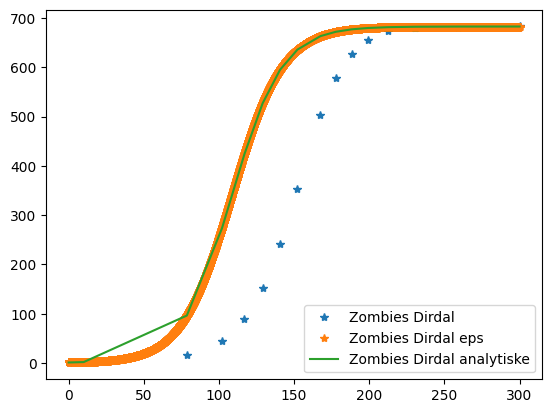

In [308]:
def rhs_z(t,c, beta, N):
    return np.array([beta*c[0]*(1-c[0]/N), -beta*c[1]*(1-c[1]/N)])


Z0 = 1
c0_dirdal= np.array([Z0,N_dirdal-Z0])
eps = 10
eps1 = 1e-5
t1, Z1 = ode_solver_adaptiv(0, 300, c0_dirdal, eps1,  rhs_z,'Euler', beta, N_dirdal)
t, Z = ode_solver_adaptiv(0, 300, c0_dirdal, eps,  rhs_z,'Euler', beta, N_dirdal)
_, Z_d = SZ_solution(t, N_dirdal)
plt.plot(t, Z[:,0],'*', label="Zombies Dirdal")
plt.plot(t1, Z1[:,0],'*', label="Zombies Dirdal eps")
plt.plot(t, Z_d, label="Zombies Dirdal analytiske")
plt.legend()
print(np.round(t),t.size)


meneske igjen: 3057.0
meneske igjen: 91.0


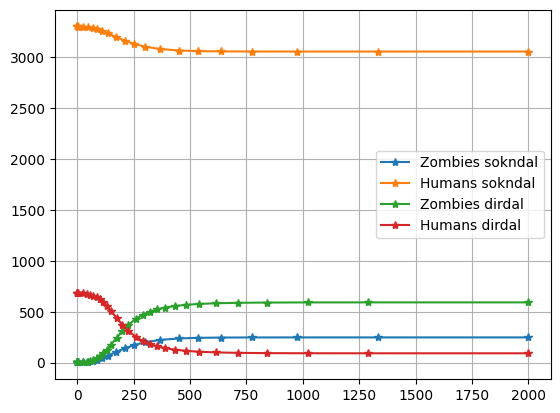

In [334]:
def rhs_z(t, c, beta, N):
    beta_t = beta[0]*np.exp(-1*beta[1]*t)
    return (np.array([beta_t*c[0]*(1-c[0]/N), -beta_t*c[1]*(1-c[1]/N)]))

Z0 = 1
eps = 0.1

T_sokndal = 48
landa_sokndal = -1*np.log(0.6)/T_sokndal
beta_t_sokndal = np.array([beta,landa_sokndal])
c0_sokndal= np.array([Z0,N_sokndal-Z0])


T_dirdal = 72
landa_dirdal = -1*np.log(0.6)/T_dirdal
beta_t_dirdal = np.array([beta,landa_dirdal])
c0_dirdal= np.array([Z0,N_dirdal-Z0])


t_sokndal, Z_sokndal = ode_solver_adaptiv(0, 2000, c0_sokndal, eps,  rhs_z,'RK2', beta_t_sokndal, N_sokndal)
t_dirdal, Z_dirdal = ode_solver_adaptiv(0, 2000, c0_dirdal, eps,  rhs_z,'RK2', beta_t_dirdal, N_dirdal)

plt.plot(t_sokndal, Z_sokndal[:,0], '-*', label="Zombies sokndal")   # first variable
plt.plot(t_sokndal, Z_sokndal[:,1], '-*', label="Humans sokndal")    # second variable

plt.plot(t_dirdal, Z_dirdal[:,0], '-*', label="Zombies dirdal")   # first variable
plt.plot(t_dirdal, Z_dirdal[:,1], '-*', label="Humans dirdal")    # second variable

plt.legend()
plt.grid()
print("meneske igjen:", np.floor(Z_sokndal[-1,1]))
print("meneske igjen:", np.floor(Z_dirdal[-1,1]))


In [66]:
def rhs_SDZR(t,c, K):

    S, E, Z, R = c
    beta, sigma, a, N ,_= K
    SZ = S*Z/N

    d_S = -(beta*SZ)
    d_E = beta*SZ-sigma*E
    d_Z = sigma*E-a*SZ
    d_R = a*SZ


    return np.array([d_S,d_E,d_Z,d_R])

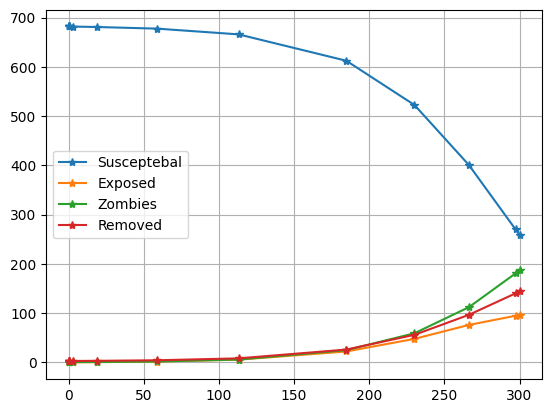

In [67]:
t_dirdal,Z_dirdal = ode_solver_adaptiv(0, 300, c0_dirdal, eps,  rhs_SDZR,'RK4', K)

plt.plot(t_dirdal, Z_dirdal[:,0], '-*', label="Susceptebal")   #
plt.plot(t_dirdal, Z_dirdal[:,1], '-*', label="Exposed")   #
plt.plot(t_dirdal, Z_dirdal[:,2], '-*', label="Zombies")   #
plt.plot(t_dirdal, Z_dirdal[:,3], '-*', label="Removed")   #
plt.legend()
plt.grid()


In [326]:

def omega(t, a, attacks):
    """
    Zombie attack function
    Input
    -----
    t: float, time
    a: float, strength of attacks
    attacks: a list with times for attacks
    Output
    ------
    sys[0]: float
    """
    return a*np.sum([np.exp(-.5*(t-ti)**2) for ti in attacks])

def rhs_SDZR_attacks(t,c, K,attacks):

    """
    Zombie attack function
    Input
    -----
    t: float, time
    c: float, array of S, E, Z, R
    K: float, array of Konstant : beta, sigma, alfa, N, a
    attacks: a list with times for attacks
    Output
    ------
    c : array, array of d_S,d_E,d_Z,d_R
    """


    S, E, Z, R = c
    beta, sigma, alfa, N, a = K
    w_t = omega(t, a, attacks)

    SZ = S*Z/N

    if Z<1 and E<1 and t >100:
        beta = 0
        sigma = 0
    d_S = -(beta*SZ)
    d_E = beta*SZ-sigma*E
    d_Z = sigma*E-(alfa+w_t)*SZ
    d_R = (alfa+w_t)*SZ


    return np.array([d_S,d_E,d_Z,d_R])

In [404]:
# attacks occur at specified times following the zombie outbreak:
attacks_1 = [np.linspace(10, 400,10)] # hrs
attacks = [100,124,148,172,196] # hrs

eps = 0.001

t_final = 250
N = N_dirdal
alfa = 0.02 #0.02
beta = 0.06 #0.06
sigma = 1/24
a  = 20*beta #20
w_t = 0

Z0 = 1
S0 = N - Z0
E0 = 0
R0 = beta/(alfa +w_t)
print('beta/alfa = ',beta/alfa)

c0_dirdal= np.array([S0,E0,Z0,R0])
K = np.array([beta,sigma,alfa,N,a])

beta/alfa =  3.0


meneske igjen: 664.0


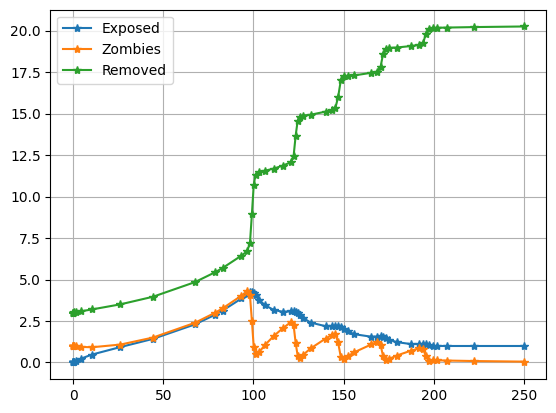

In [405]:
t_dirdal,Z_dirdal = ode_solver_adaptiv(0, t_final, c0_dirdal, eps,  rhs_SDZR_attacks,'RK4', K, attacks)

#plt.plot(t_dirdal, Z_dirdal[:,0], '-*', label="Susceptebal")   #
plt.plot(t_dirdal, Z_dirdal[:,1], '-*', label="Exposed")   #
plt.plot(t_dirdal, Z_dirdal[:,2], '-*', label="Zombies")   #
plt.plot(t_dirdal, Z_dirdal[:,3], '-*', label="Removed")   #

plt.legend()
plt.grid()
print("meneske igjen:", np.floor(Z_dirdal[-1,0]))

meneske igjen: uten angrip 647.0
meneske igjen: med angrip 647.0


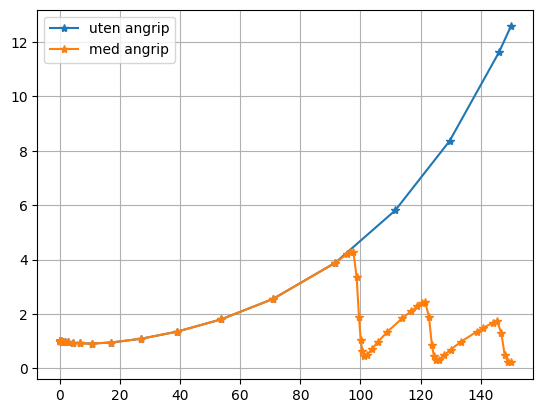

In [396]:
t_2,Z_2 = ode_solver_adaptiv(0, t_final, c0_dirdal, eps,  rhs_SDZR_attacks,'RK4', K, attacks)
t_1,Z_1 = ode_solver_adaptiv(0, t_final, c0_dirdal, eps,  rhs_SDZR,'RK4', K)

plt.plot(t_1, Z_1[:,2], '-*', label="uten angrip")   #
plt.plot(t_2, Z_2[:,2], '-*', label="med angrip")   #

plt.legend()
plt.grid()
print("meneske igjen: uten angrip", np.floor(Z_1[-1,0]))
print("meneske igjen: med angrip", np.floor(Z_1[-1,0]))

In [70]:
# attacks occur at specified times following the zombie outbreak:
attacks_1 = [np.linspace(10, 400,10)] # hrs
attacks = [100,124,148,172,196] # hrs

eps = 0.1

t_final = 600
N = N_dirdal
alfa = 0.02
beta = 0.06
sigma = 1/24
a  = 40*beta
w_t = 0

Z0 = 1
S0 = N - Z0
E0 = 0
R0 = beta/(alfa +w_t)

c0_dirdal= np.array([S0,E0,Z0,R0])
K = np.array([beta,sigma,alfa,N,a])

beta/alfa =  3.0


In [200]:
def beta_f(t,beta,landa):

    """
    Zombie attack function
    Input
    -----
    t: float, time
    beta: float, array of Konstant beta0
    landa: float, array of Konstant : landa
    Output
    ------
    c : array, fusjen of beta_f(t)
    """

    return beta*np.exp(-1*landa*t)

def rhs_SDZR_EBOLA(t,c, K):

    """
    Zombie attack function
    Input
    -----
    t: float, time
    c: float, array of S, E, Z, R
    K: float, array of Konstant : beta, sigma, gamma, N,landa
    Output
    ------
    c : array, array of d_S,d_E,d_Z,d_R
    """


    S, E, Z, R = c
    beta_0,sigma, gamma, N ,landa= K
    beta = beta_f(t,beta_0,landa)
    SZ = S*Z/N

    d_S = -(beta*SZ)
    d_E = beta*SZ-sigma*E
    d_Z = sigma*E-gamma*Z
    d_R = gamma*Z


    return np.array([d_S,d_E,d_Z,d_R])

In [113]:
def read_file(file_path):
    x = [0]
    y_total = [0]
    y = [0]
    l = 0
    with open(file_path, "r") as f:
        next(f) #hopper over første lingje
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) == 3:
                l = l + 1
                days = int(parts[1])
                cases = int(parts[2])
                x.append(days)
                y_total.append(y_total[l-1]+cases)
                y.append(cases)
    return np.array([x,y_total,y])


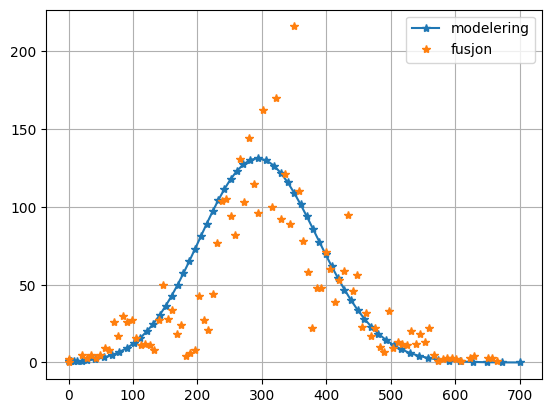

In [410]:

Z0 = 1
S0 = N - Z0
E0 = 0
R0 = beta/(alfa +w_t)
c0= np.array([S0,E0,Z0,R0])
gamma = 1/7
sigma = 1/9.7
N = 10e7
t_final = 700
eps = 0.001
T_probabilety = 50
porsent = 60
#landa = -1*np.log(porsent/100)/T_probabilety
landa = 0.002 # 0.002
beta = 0.255 # 0.25


file_path = "ebola_cases_guinea.dat"
x_f,_,y_f = read_file(file_path)
t,Z = ode_solver_adaptiv(0, t_final, c0, eps,  rhs_SDZR_EBOLA,'RK4', np.array([beta,sigma,gamma,N,landa]))

plt.plot(t,Z[:,2],'-*', label="modelering")
plt.plot(x_f,y_f,'*', label="fusjon")

plt.legend()
plt.grid()


[9.99999990e+07 9.99999990e+07 1.00000000e+08 1.00000013e+08]
